# Importing Libraries

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential, load_model
from keras.optimizers import Adam,SGD,RMSprop


# Displaying Images

In [2]:
picture_size = 48
folder_path = "./images/"

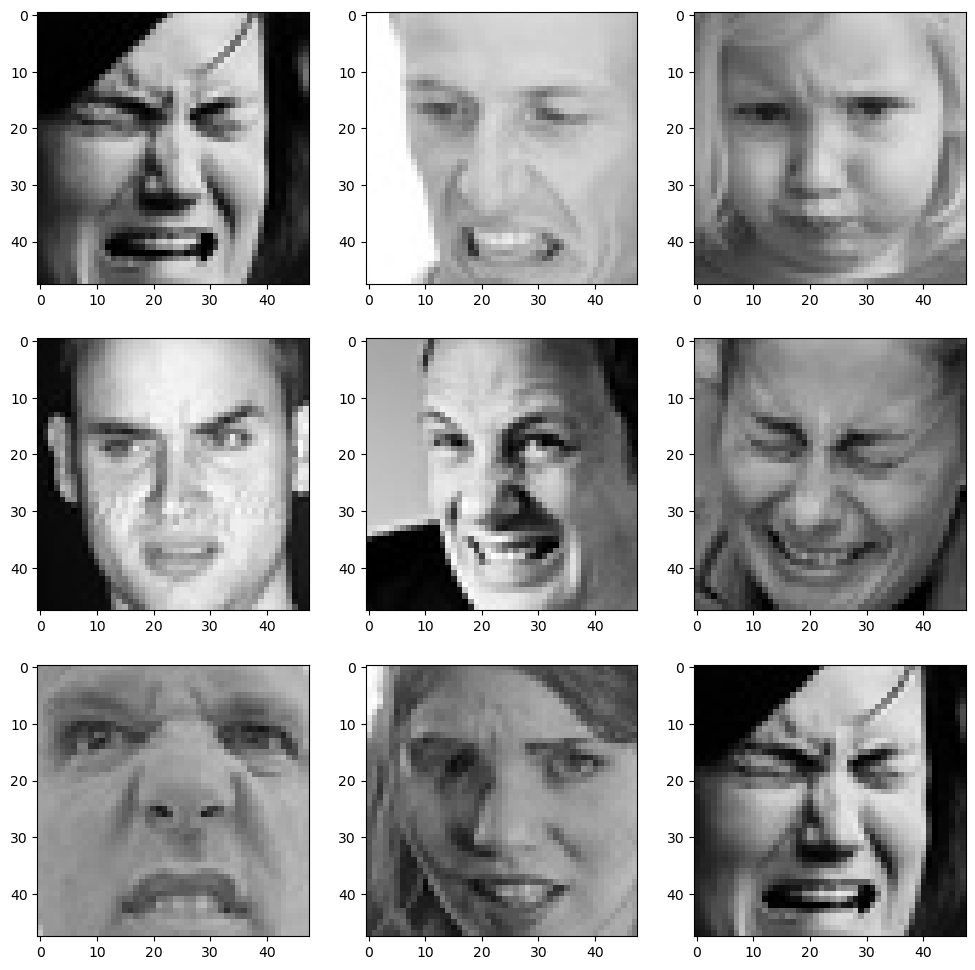

In [3]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Making Training and Validation Data (with generator)

In [8]:
batch_size  = 128

# datagen_train  = ImageDataGenerator()
# datagen_val = ImageDataGenerator()

# ImageDataGenerator with rescaling
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validate",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Making Training and Validation Data (without generator, old fashioned way)

In [9]:

images_data_train = []
images_labels_train = []

images_data_val = []
images_labels_val = []

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']
emotion_folders = ['angry','disgust','fear','happy','neutral', 'sad', 'surprise']

# Calculates and fills the vector emotion_size with the number of files in each "emotion" folder.
# Choose train_or_validate to "train" or "validate". 
def get_nr_of_files_in_folders(emotion_folders, folder_path, train_or_validate, emotion_size):

    for j in range(len(emotion_folders)):
        
       folder = folder_path + f"{train_or_validate}/" + emotion_folders[j]

       # Using os.scandir() to get only files in a folder
       with os.scandir(folder) as entries:
            num_files = len([entry.name for entry in entries if entry.is_file()])

       emotion_size.append(num_files)


# emotion_size_train = [3993, 436, 4103, 7164, 4982, 4938, 3205]
# emotion_size_val = [960, 111, 1018, 1825, 1216, 1139, 797]

emotion_size_train = []
emotion_size_val = []

get_nr_of_files_in_folders(emotion_folders, folder_path, "train", emotion_size_train)
get_nr_of_files_in_folders(emotion_folders, folder_path, "validate", emotion_size_val)

# Function that creates the training data with the labels.

def createDataFromImagesTrainSet(emotion_labels, emotion_folders, emotion_size_train):

   index = 0

   for j in range (len(emotion_folders)):
    
      for i in range(1, emotion_size_train[j], 1):

          img = load_img(folder_path+"train/"+emotion_folders[j]+"/"+
                     os.listdir(folder_path + "train/" + emotion_folders[j])[i], target_size=(picture_size, picture_size), color_mode='grayscale')

          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          # image_data = image_data_raw.reshape(1, -1)
          images_labels_train.append(emotion_labels[j])
          images_data_train.append(image_data_raw)
     
          index += 1

# Function that creates the testing data with the labels.

def createDataFromImagesValSet(emotion_labels, emotion_folders, emotion_size_val):

   index = 0

   for j in range (len(emotion_folders)):
    
      for i in range(1, emotion_size_val[j], 1):

          img = load_img(folder_path+"validate/"+emotion_folders[j]+"/"+
                     os.listdir(folder_path + "validate/" + emotion_folders[j])[i], target_size=(picture_size, picture_size), color_mode='grayscale')

          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          # image_data = image_data_raw.reshape(1, -1)
          images_labels_val.append(emotion_labels[j])
          images_data_val.append(image_data_raw)
     
          index += 1


# Creates the training data with the labels.
createDataFromImagesTrainSet(emotion_labels, emotion_folders, emotion_size_train)

# Creates the testing data with the labels.
createDataFromImagesValSet(emotion_labels, emotion_folders, emotion_size_val)


# Convert to an np array.
    
images_labels_train = np.array(images_labels_train)
images_data_train = np.array(images_data_train)

images_labels_val = np.array(images_labels_val)
images_data_val = np.array(images_data_val)


# Manipulating the input and output data.

In [186]:

# Generate a permutation of indices for train data.
permutation_train = np.random.permutation(len(images_data_train))

# Shuffle twice the train data and labels using the permutation.
images_data_train = images_data_train[permutation_train]
images_labels_train = images_labels_train[permutation_train]

permutation_train2 = np.random.permutation(len(images_data_train))

images_data_train = images_data_train[permutation_train2]
images_labels_train = images_labels_train[permutation_train2]

# Generate a permutation of indices for validation data.
permutation_val = np.random.permutation(len(images_data_val))

# Shuffle twice the validation data and labels using the permutation.
images_data_val = images_data_val[permutation_val]
images_labels_val = images_labels_val[permutation_val]

permutation_val2 = np.random.permutation(len(images_data_val))

images_data_val = images_data_val[permutation_val2]
images_labels_val = images_labels_val[permutation_val2]

# Make the emotion cathegories to integer values and one-hot encoding.
label_encoder = LabelEncoder()
integer_labels_train = label_encoder.fit_transform(images_labels_train)
integer_labels_val = label_encoder.transform(images_labels_val) 

images_labels_train_cat = to_categorical(integer_labels_train)
images_labels_val_cat = to_categorical(integer_labels_val)



In [11]:
# print(images_labels_train_cat[:20], images_labels_train[:20])
# print(images_labels_val_cat[:20], images_labels_val[:20])

# Model Building

In [188]:

# The neural network model with convutional and dense layers.

no_of_classes = 7

model = Sequential()

# model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))

# Define input shape here.
model.add(Input(shape=(48, 48, 1)))  

#1st CNN layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.01)))
# model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5,5), padding = 'same', kernel_regularizer=l2(0.01)))
# model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3), padding = 'same', kernel_regularizer=l2(0.01)))
# model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=l2(0.01)))
# model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(1024, kernel_regularizer=l2(0.01)))
# model.add(Dense(1024))
# model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))
# model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer (no_of_classes = 7 emotions).
model.add(Dense(no_of_classes, activation='softmax'))

my_learning_rate = 0.0005

opt = Adam(learning_rate = my_learning_rate)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_96 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_97 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 1024)           │         4,09

 Total params: 8,414,727 (32.10 MB)

 Trainable params: 8,409,223 (32.08 MB)

 Non-trainable params: 5,504 (21.50 KB)

# Fitting the Model with Training and Validation Data 

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./modelcheck_emotion.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate = my_learning_rate),
              metrics=['accuracy'])




# Training models.

In [ ]:

# Fit the model with the generator model.

# history = model.fit(train_set,
#                    steps_per_epoch=train_set.n//train_set.batch_size,
#                    epochs=epochs,
#                    validation_data = test_set,
#                    validation_steps = test_set.n//test_set.batch_size,
#                    callbacks=callbacks_list
#                    )

In [22]:

# Fit the model where x (images) and y (emotions) has been "loaded" from file.

batch_size_img = 128

history = model.fit(x = images_data_train, y = images_labels_train_cat,
                    steps_per_epoch = max(len(images_data_train) // batch_size_img - 5 , 1),
                    epochs = epochs,
                    batch_size = batch_size_img,
                    validation_data = (images_data_val, images_labels_val_cat),
                    validation_steps = max(len(images_data_val) // batch_size_img - 5, 1),
                    callbacks=callbacks_list
                    )


Epoch 1/48
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5424 - loss: 2.0763
Epoch 1: val_accuracy improved from -inf to 0.12203, saving model to ./modelcheck.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 152s 680ms/step - accuracy: 0.5424 - loss: 2.0765 - val_accuracy: 0.1220 - val_loss: 5.4800 - learning_rate: 5.0000e-04
Epoch 2/48
  6/220 ━━━━━━━━━━━━━━━━━━━━ 1:52 525ms/step - accuracy: 0.5567 - loss: 2.0780

D:\Program\Programming\Anaconda3\envs\AI1\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.12203 to 0.48407, saving model to ./modelcheck.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5447 - loss: 2.1000 - val_accuracy: 0.4841 - val_loss: 2.2882 - learning_rate: 5.0000e-04
Epoch 3/48
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.5474 - loss: 2.0703
Epoch 3: val_accuracy did not improve from 0.48407
220/220 ━━━━━━━━━━━━━━━━━━━━ 146s 664ms/step - accuracy: 0.5474 - loss: 2.0703 - val_accuracy: 0.3642 - val_loss: 2.3488 - learning_rate: 5.0000e-04
Epoch 4/48
  6/220 ━━━━━━━━━━━━━━━━━━━━ 1:51 520ms/step - accuracy: 0.5766 - loss: 1.9574
Epoch 4: val_accuracy did not improve from 0.48407
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5527 - loss: 2.0069 - val_accuracy: 0.2731 - val_loss: 2.5591 - learning_rate: 5.0000e-04
Epoch 5/48
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5266 - loss: 2.1638
Epoch 5: val_accuracy did not improve from 0.48407
220/220 ━━━━━━━━━━━━━━━━━━━━ 146s 663ms/step - a

# Saving the models (and loading checkpoint model with best accuracy).

In [ ]:

# model.save(filepath = "model.h5", save_format = 'h5', include_optimizer = False)
model.save(filepath = "model_emotion.keras", include_optimizer = False)

# model.save(filepath = "model_all.h5", save_format = 'h5')
model.save(filepath = "model_all_emotion.keras")

model2 = load_model("modelcheck_emotion.keras")


In [ ]:
# Load the models from disk for prediction, accuracy and confusion matrix.

model2 = load_model("modelcheck_emotion.keras")
model = load_model("model_all_emotion.keras")

# Calculate the accuracy from the validation data.

In [191]:

# Create predictions from the validation data (from last trained model (model) and best accuracy checkpoint model (model2)).

pred_val = model.predict(images_data_val)
pred_val2 = model2.predict(images_data_val)


221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step


In [192]:
# Make predictions and evaluate the model.

# Accuracy from last trained model (model).

pred_labels_val = np.argmax(pred_val, axis=1)
true_labels_val = np.argmax(images_labels_val_cat, axis=1)
accuracy = np.mean(pred_labels_val == true_labels_val)
print(f"Accuracy: {accuracy}")

# Accuracy from best accuracy checkpoint model (model2).

pred_labels_val2 = np.argmax(pred_val2, axis=1)
accuracy_best = np.mean(pred_labels_val2 == true_labels_val)
print(f"Accuracy (last best prediction): {accuracy_best}")


Accuracy: 0.6754497804221561
Accuracy (last best prediction): 0.6754497804221561


# Plotting Accuracy & Loss

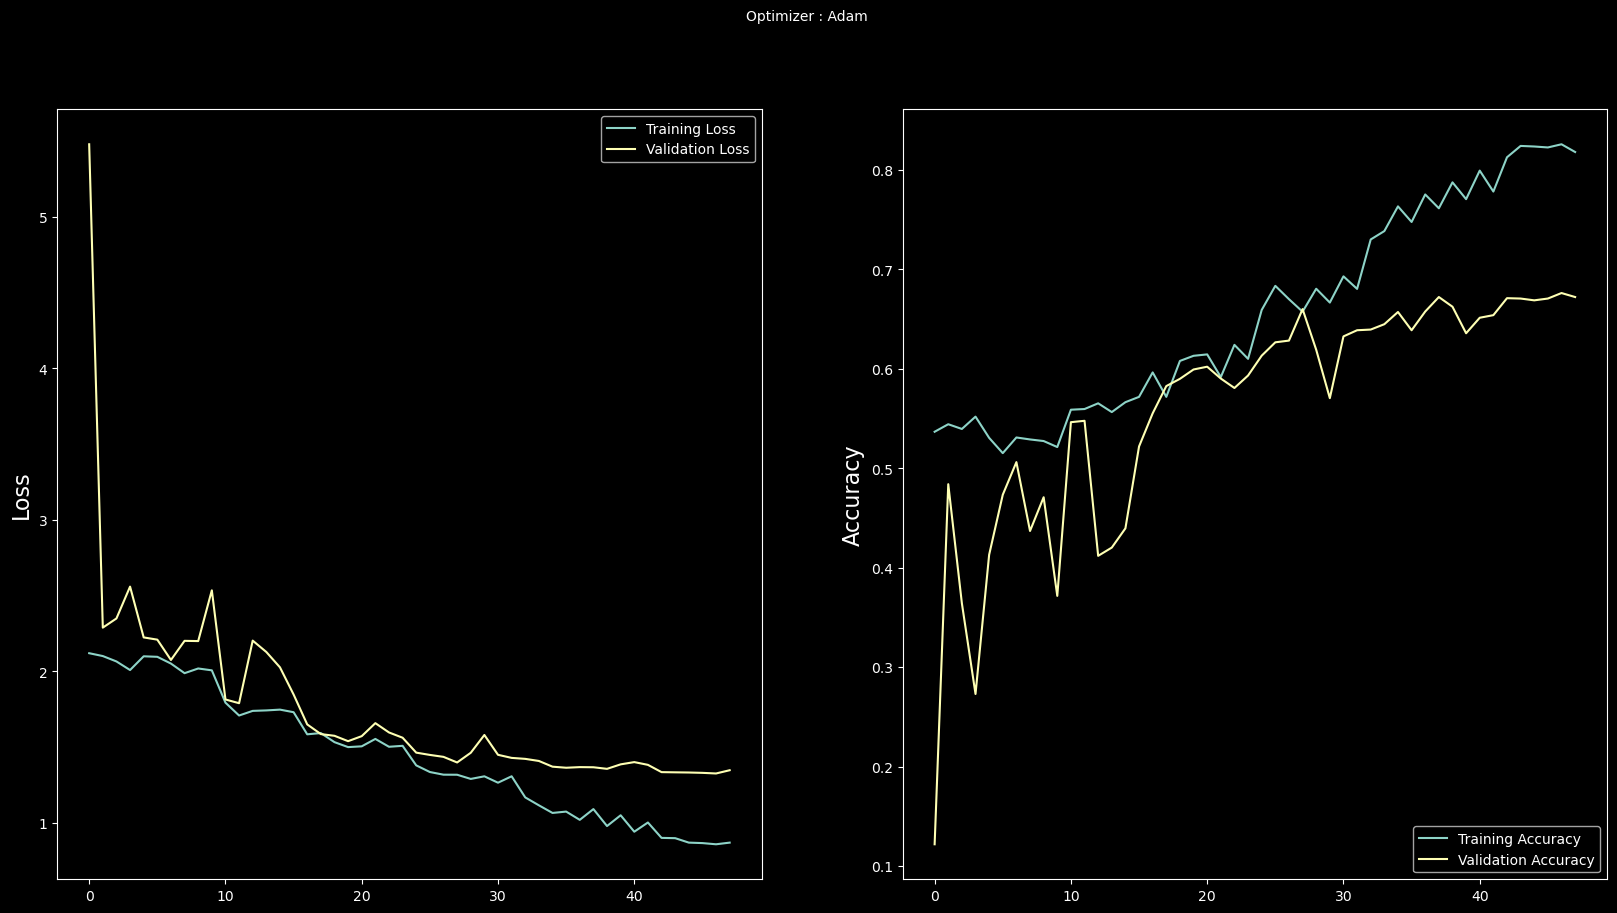

In [26]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix

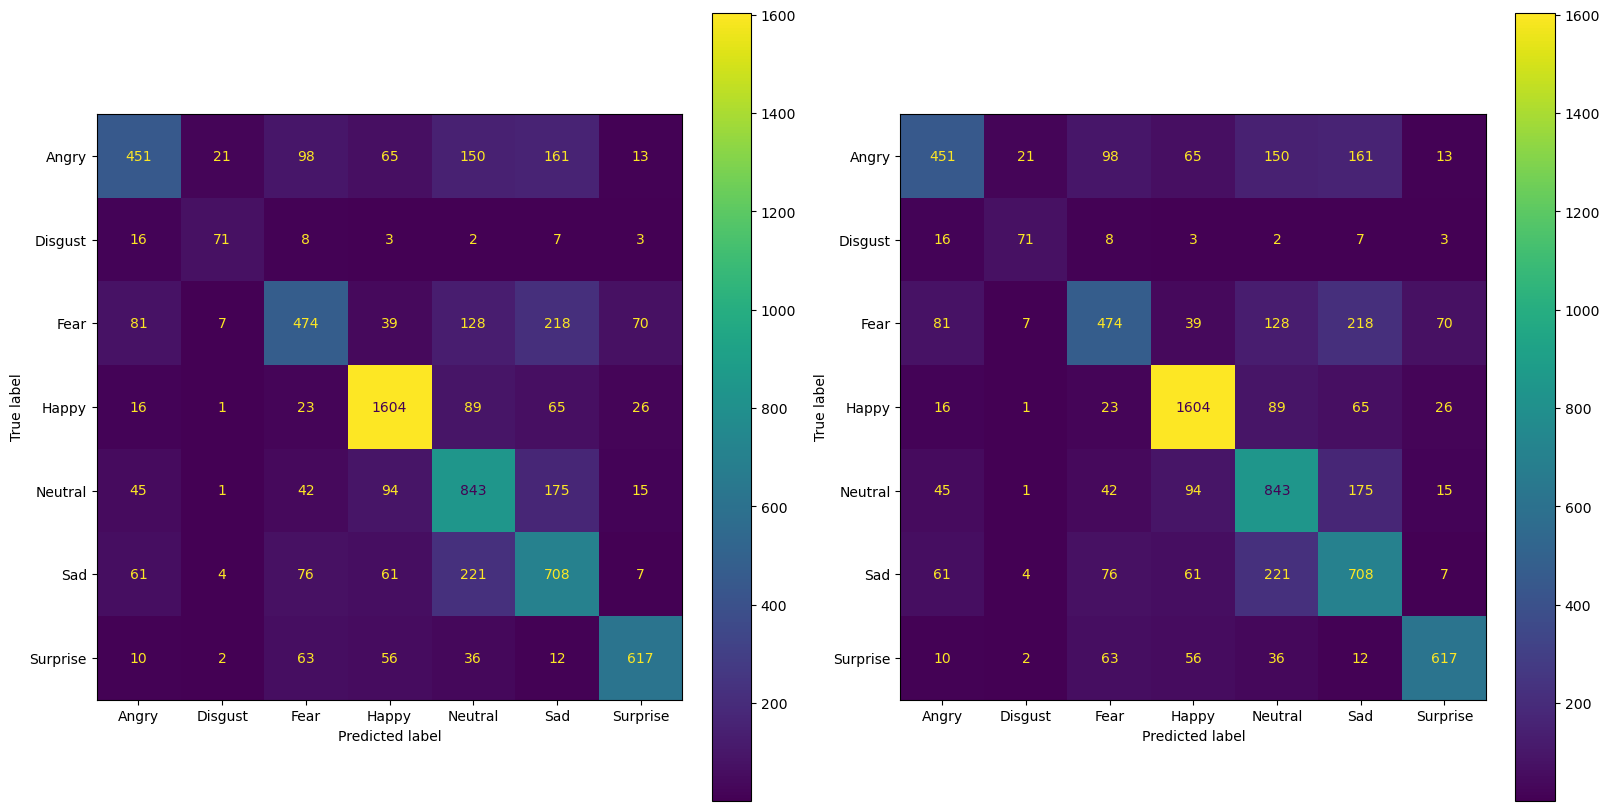

In [193]:
# Calculate the confusion matrix from the predicted and true values (from model (last saved configuration) and 
# model 2 (the best configuration)).

cm1 = confusion_matrix(true_labels_val, pred_labels_val)
cm2 = confusion_matrix(true_labels_val, pred_labels_val2)

fig, axs = plt.subplots(1, 2, figsize = (16, 8), layout='constrained')
ConfusionMatrixDisplay(cm1, display_labels = emotion_labels).plot(ax=axs[0])
ConfusionMatrixDisplay(cm2, display_labels = emotion_labels).plot(ax=axs[1])
